In [64]:
!pip install pandas statsmodels scikit-learn


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем зависимости 

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from os.path import join as path_join
import os
import datetime

In [66]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

In [67]:
power_statistic_dir = path_join(os.getcwd(), "power_consumption_statistics")
classroom_schedule = path_join(os.getcwd(), "classroom_schedule")

Словарь с счетчиками (серийный номер счетчика: номер аудитории)

In [68]:
counters_to_rooms = {
"4101468": "371",
"4101472": "365",
"4101473": "361",
"4101471": "369",
"4101467": "381",
"4089401": "375"
}


Загружаем датасет из файла

In [69]:
power_df = pd.read_csv(path_join(power_statistic_dir, "power_25.02.2023.csv"), sep=";")

In [70]:
counter_id = "4101468"
data_colum_name = "total"
print("Find counters:", power_df.counter.unique().tolist())
print("Selected counter", counter_id, "located in room", counters_to_rooms.get(counter_id))

Find counters: [4101474, 4101473, 4101468, 4101467, 4101469, 4101471, 4089401, 4101472]
Selected counter 4101468 located in room 371


Форматитуем данные и фильтруем их по номеру счетчика

In [71]:
power_df = power_df.query(f"counter == {counter_id}")
power_df.datetime = pd.to_datetime(power_df.datetime, format="%Y-%m-%d %H:%M:%S")
power_df.sort_values(by='datetime', ascending = True, inplace = True)
power_df.set_index(["datetime"])
power_df_sample = power_df.loc[(power_df.datetime>=datetime.datetime(year=2022, month=12, day=1, hour=0)) & (power_df.datetime<=datetime.datetime(year=2023, month=2, day=2, hour=0))]
# power_df_sample = power_df


Отобразим загруженные данные на графике

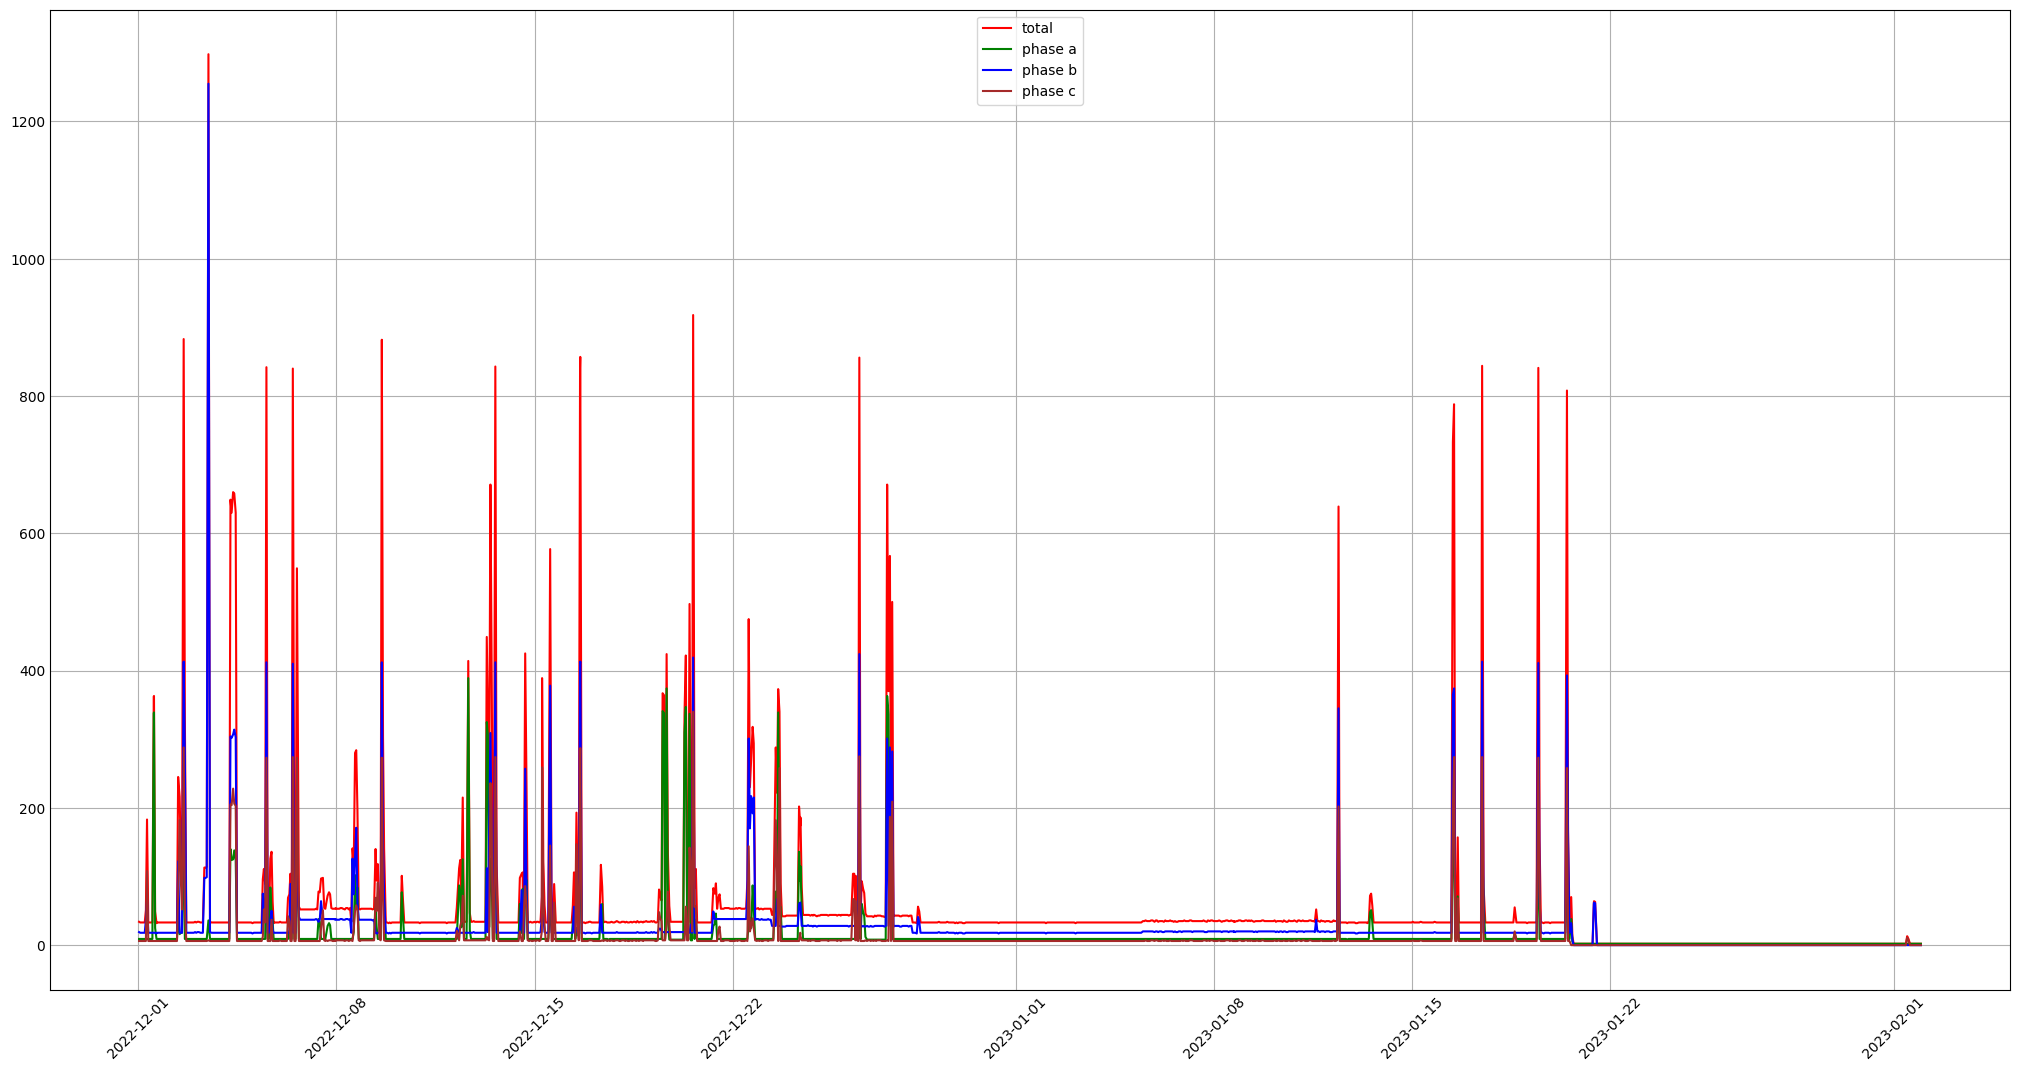

In [72]:
# length = 1000
def show_sample(power_df_sample, datetime_is_index: bool = True):
    x = list(power_df_sample.datetime) if not datetime_is_index else list(power_df_sample.index)

    plt.style.use('_mpl-gallery')
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    fig.set_dpi(100)


    y = list(power_df_sample.total)
    ax.plot(x, y, linewidth=1.5, color='red', label="total")

    y = list(power_df_sample.phase_a)
    ax.plot(x, y, linewidth=1.5, color='green', label="phase a")

    y = list(power_df_sample.phase_b)
    ax.plot(x, y, linewidth=1.5, color='blue', label="phase b")

    y = list(power_df_sample.phase_c)
    ax.plot(x, y, linewidth=1.5, color='brown', label="phase c")

    plt.legend(loc='upper center')
    plt.xticks(rotation=45)

    plt.show()

show_sample(power_df_sample, False)

Разделим датасет на тренировочный и тестовый наборы данных

In [73]:
from_datetime = datetime.datetime(year=2022, month=9, day=1, hour=0)
separation_datetime = datetime.datetime(year=2022, month=11, day=1, hour=0)
to_datetime = datetime.datetime(year=2022, month=11, day=15, hour=0)
train_df = power_df.loc[(power_df.datetime>=from_datetime) & (power_df.datetime<=separation_datetime)]
test_df = power_df.loc[(power_df.datetime>separation_datetime) & (power_df.datetime <= to_datetime)]
train_df

,datetime,counter,phase_a,phase_b,phase_c,total
71343,2022-09-01 00:19:08,4101468,5.0,10.0,6.0,21.0
71346,2022-09-01 00:19:08,4101468,5.0,10.0,6.0,21.0
71354,2022-09-01 01:26:50,4101468,5.0,10.0,7.0,22.0
71359,2022-09-01 01:26:50,4101468,5.0,10.0,7.0,22.0
71368,2022-09-01 02:32:53,4101468,5.0,10.0,6.0,21.0
...,...,...,...,...,...,...
39431,2022-10-31 22:43:07,4101468,9.0,11.0,6.0,26.0
39446,2022-10-31 23:46:17,4101468,9.0,11.0,6.0,26.0
39441,2022-10-31 23:46:17,4101468,9.0,11.0,6.0,26.0
39445,2022-10-31 23:56:24,4101468,9.0,10.0,6.0,25.0


Отобразим на графике оба датасета

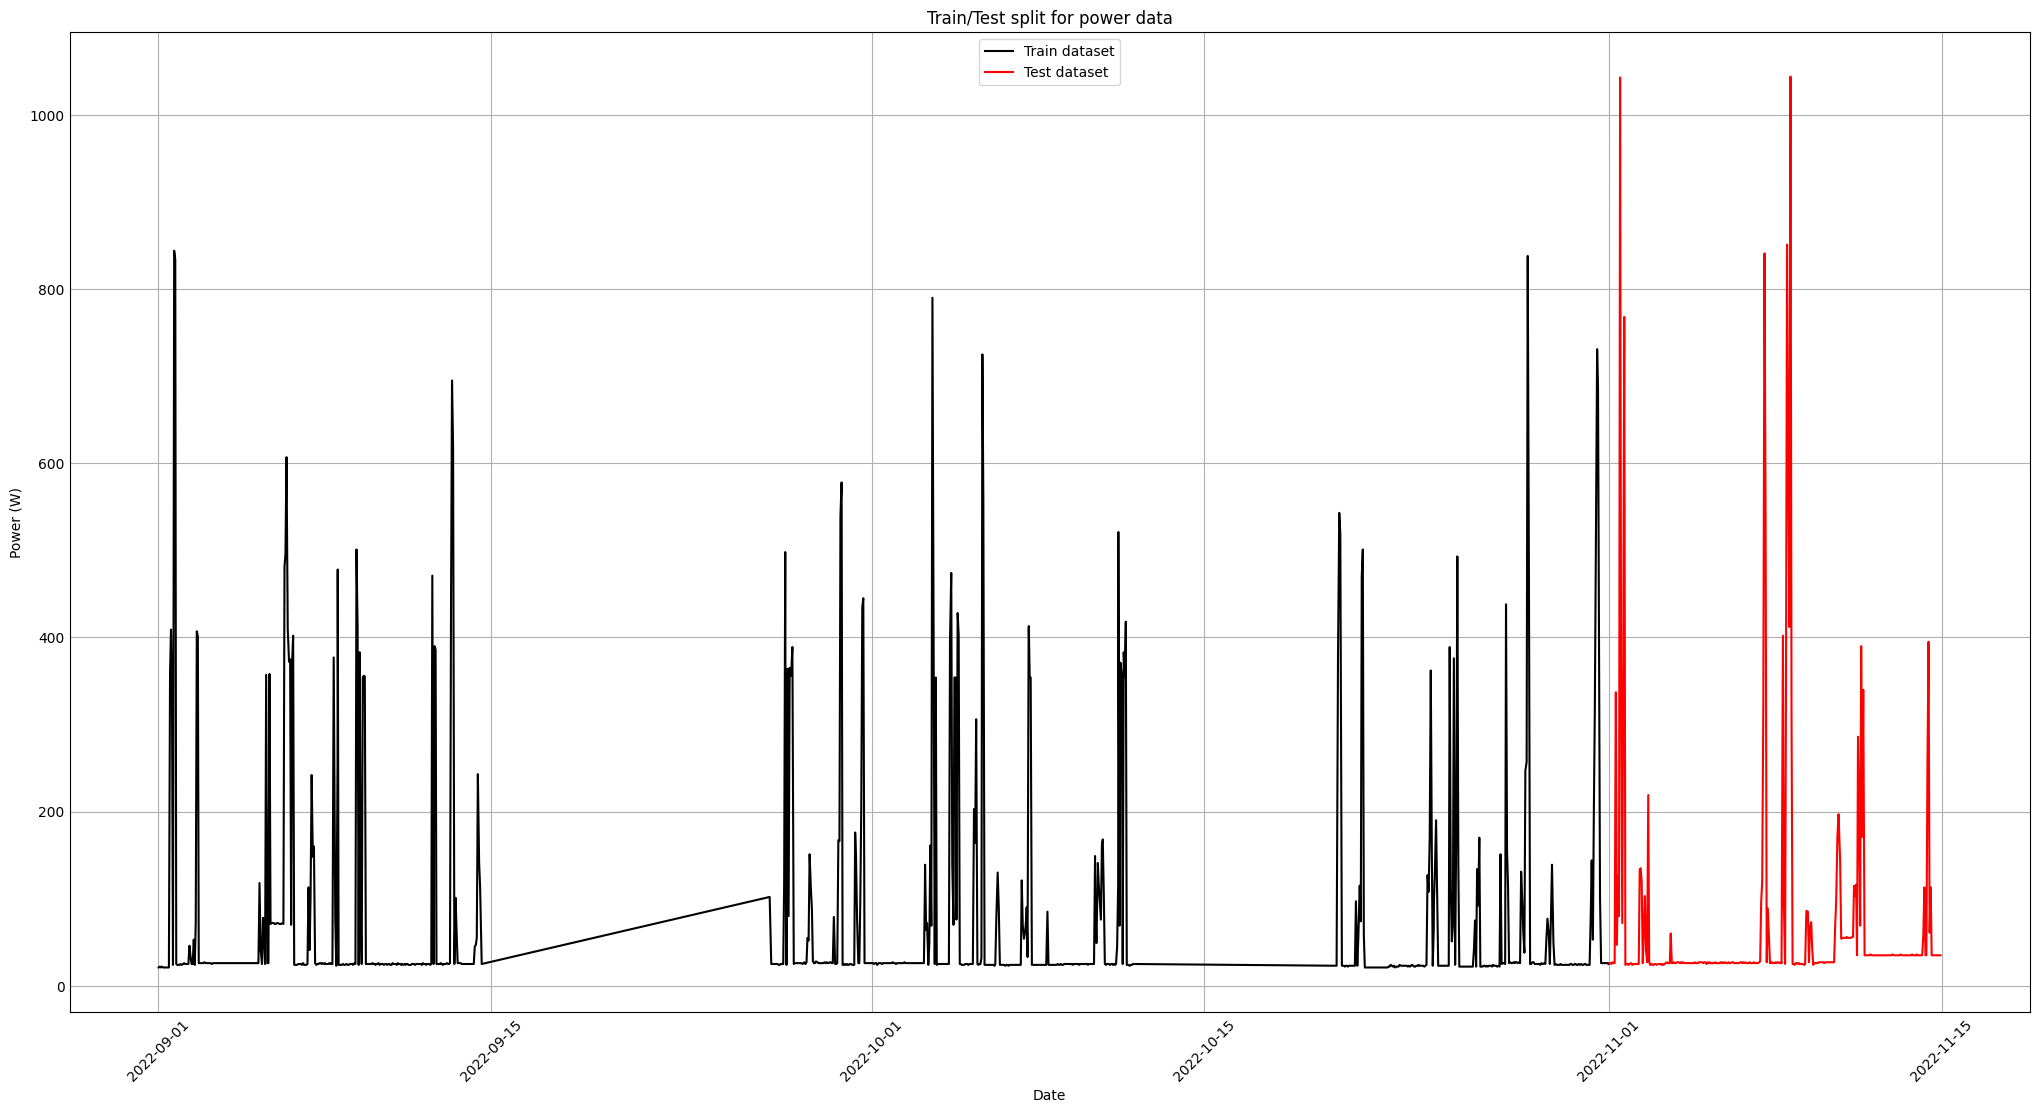

In [74]:
train_x = list(train_df.datetime)
test_x = list(test_df.datetime)

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)

plt.plot(train_x, train_df[data_colum_name], color = "black", label = "Train dataset")
plt.plot(test_x, test_df[data_colum_name], color = "red", label = "Test dataset")
plt.ylabel('Power (W)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for power data")
plt.legend(loc='upper center')
plt.show()

Подберем наиболее подходящую модель

In [75]:
def find_best_model(model, test_df):
    y = test_df[data_colum_name]

    best_model = (0, 0, 0)
    best_rmse = 1_000_000

    value1, value2, value3 = 0, 0, 0
    max_value = 5

    for v1 in range(max_value+1):
        for v2 in range(max_value+1):
            for v3 in range(max_value+1):
                ARMAmodel = model(y, order = (v1, v2, v3))
                try:
                    ARMAmodel = ARMAmodel.fit()
                except:
                    print("Error! Continue")
                    continue

                y_pred = ARMAmodel.get_forecast(len(test_df.index))
                y_pred_df = y_pred.conf_int(alpha = 0.05) 
                y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
                y_pred_df.datetime = test_df["datetime"]
                y_pred_out = y_pred_df["Predictions"]
                try:
                    arma_rmse = np.sqrt(mean_squared_error(test_df[data_colum_name].values, y_pred_df["Predictions"]))
                except:
                    print("blah")
                    continue
                if arma_rmse < best_rmse:
                    print((v1, v2, v3), "is better than", best_model, "|", best_rmse, "->", arma_rmse)
                    best_model = (v1, v2, v3)
                    best_rmse = arma_rmse
    return best_model,best_rmse


In [76]:

arma_best_model, best_rmse = find_best_model(SARIMAX, test_df)
print(arma_best_model, best_rmse)

(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 150.44199889344696
(0, 0, 1) is better than (0, 0, 0) | 150.44199889344696 -> 150.43863143864118
(0, 0, 2) is better than (0, 0, 1) | 150.43863143864118 -> 150.43774329816
(0, 0, 3) is better than (0, 0, 2) | 150.43774329816 -> 150.43403089780296
(0, 0, 4) is better than (0, 0, 3) | 150.43403089780296 -> 150.4334551433774
(0, 0, 5) is better than (0, 0, 4) | 150.4334551433774 -> 150.4312129488992
(0, 1, 0) is better than (0, 0, 5) | 150.4312129488992 -> 137.94600167776517
(0, 1, 2) is better than (0, 1, 0) | 137.94600167776517 -> 137.81947878617152
(0, 1, 3) is better than (0, 1, 2) | 137.81947878617152 -> 137.81944216417014
(0, 1, 4) is better than (0, 1, 3) | 137.81944216417014 -> 134.68988583280435
(0, 1, 5) is better than (0, 1, 4) | 134.68988583280435 -> 134.1924570682137
(1, 1, 1) is better than (0, 1, 5) | 134.1924570682137 -> 133.6639036332384
(1, 1, 1) 133.6639036332384


С использованием полученной модели делаем предсказание

In [77]:
y = test_df[data_colum_name]
ARMAmodel = SARIMAX(y, order = arma_best_model)
ARMAmodel = ARMAmodel.fit()

arma_pred = ARMAmodel.get_forecast(len(test_df.datetime))
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Predictions"] = ARMAmodel.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = test_df["datetime"]
arma_pred_out = arma_pred_df["Predictions"] 

Отобразим предсказание на графике и посчитаем среднеквадратичную ошибку

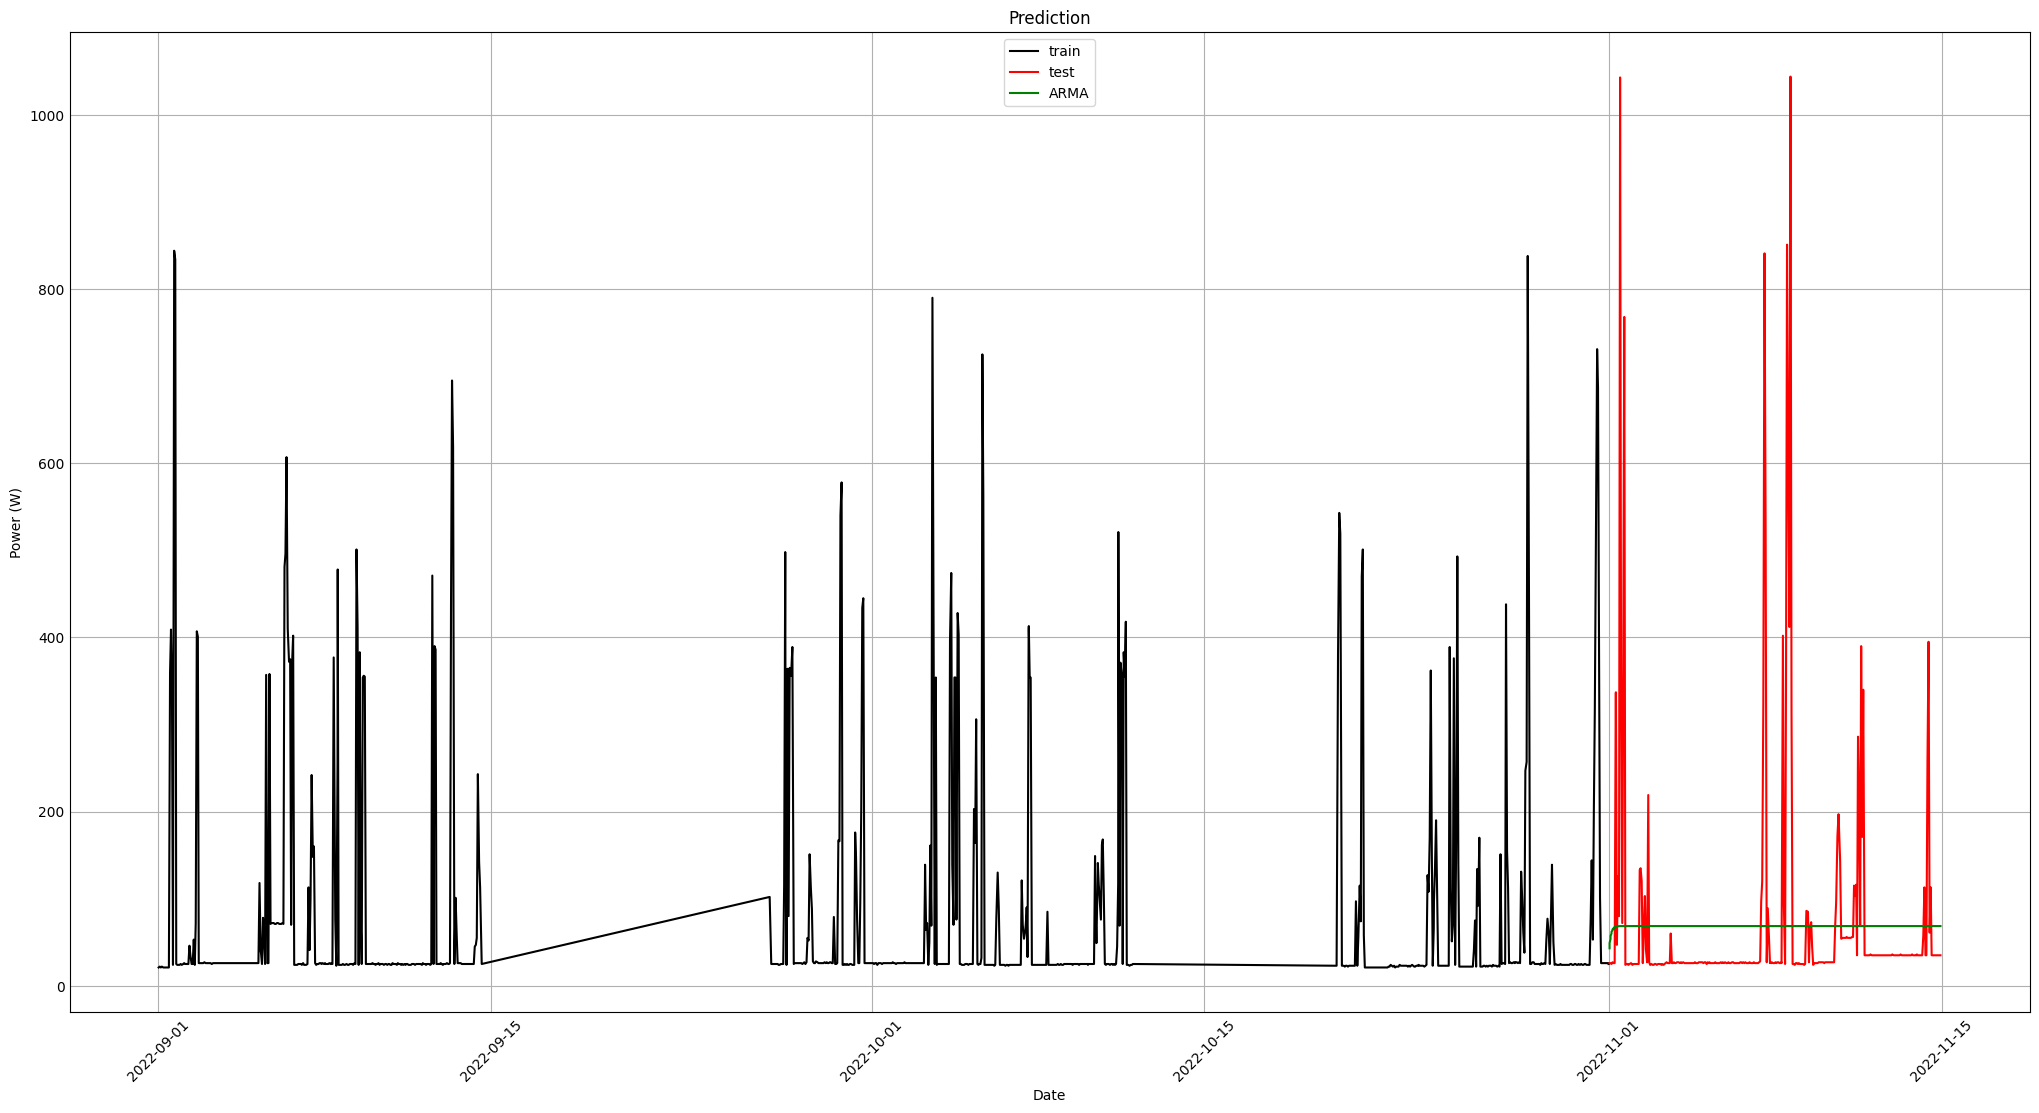

In [78]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Prediction")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(train_x, train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, test_df[data_colum_name], color = "red", label = "test")

plt.plot(arma_pred_out, color='green', label = 'ARMA')

plt.legend(loc='upper center')
plt.show()

In [79]:
arma_rmse = np.sqrt(mean_squared_error(test_df[data_colum_name].values, arma_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  133.6639036332384


Повторим то же самое с моделью ARIMA

In [80]:
arima_best_model, best_rmse = find_best_model(ARIMA, test_df)

(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 133.69504894504703
(0, 0, 1) is better than (0, 0, 0) | 133.69504894504703 -> 133.68955437586322
(0, 0, 2) is better than (0, 0, 1) | 133.68955437586322 -> 133.68633564868603
(0, 0, 3) is better than (0, 0, 2) | 133.68633564868603 -> 133.6838002002735
(0, 0, 4) is better than (0, 0, 3) | 133.6838002002735 -> 133.67908955923608
(1, 0, 0) is better than (0, 0, 4) | 133.67908955923608 -> 133.66236413372062
(2, 0, 5) is better than (1, 0, 0) | 133.66236413372062 -> 133.6328468713002
(4, 0, 3) is better than (2, 0, 5) | 133.6328468713002 -> 133.61042641111845


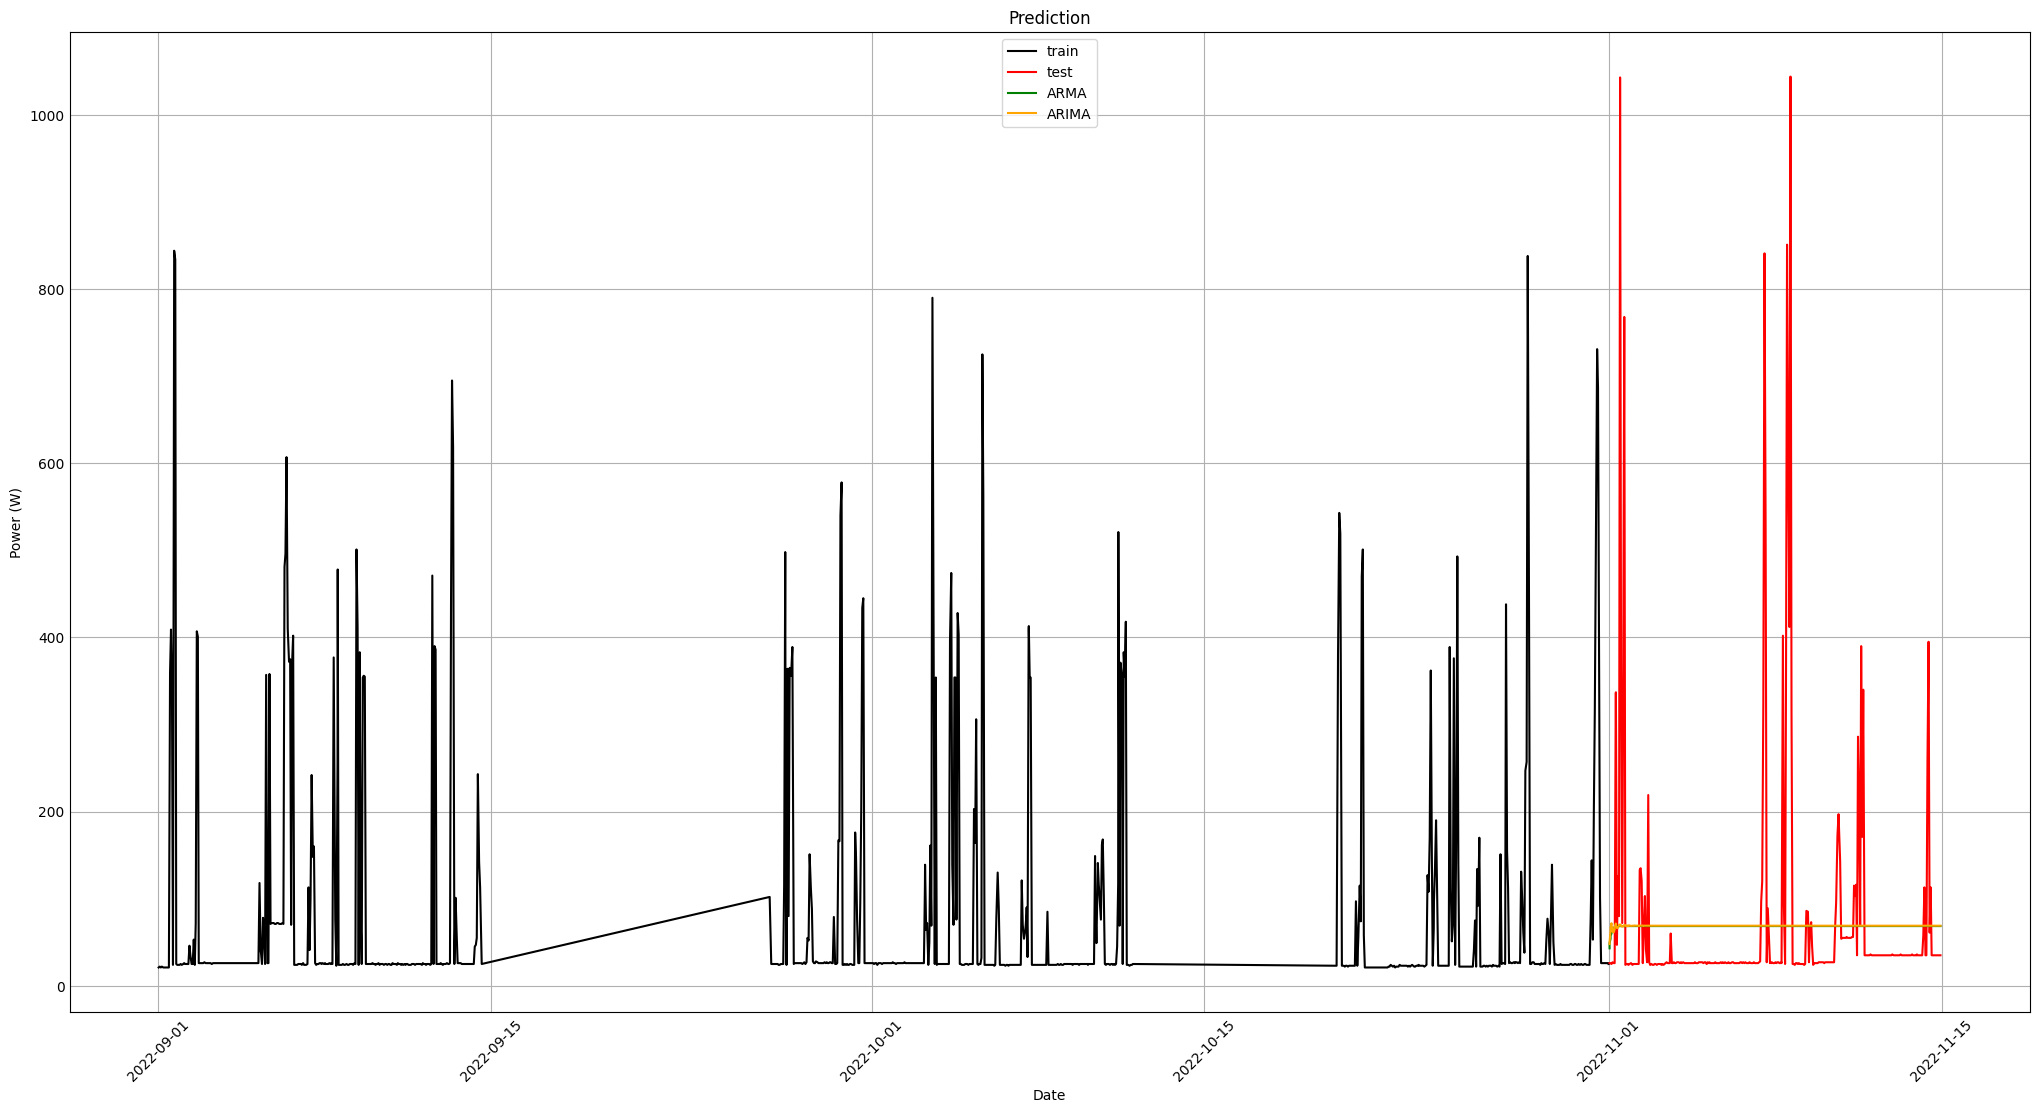

RMSE:  133.61042641111845


In [83]:
y = test_df[data_colum_name]

ARIMAmodel = ARIMA(y, order = arima_best_model)
ARIMAmodel = ARIMAmodel.fit()

arima_pred = ARIMAmodel.get_forecast(len(test_df.index))
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = test_df["datetime"]
arima_pred_out = arima_pred_df["Predictions"] 

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Prediction")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(train_x, train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, test_df[data_colum_name], color = "red", label = "test")

plt.plot(arma_pred_out, color='green', label = 'ARMA')
plt.plot(arima_pred_out, color='orange', label = 'ARIMA')

plt.legend(loc='upper center')
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_df[data_colum_name].values, arima_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

Как видно на графике и по среднеквадратичной ошибке точность предсказаний оставляет желать лучшего. Это связано с тем, что данные очень хаотичны и плохо формализованы.
Для того, чтобы улучшить качество предсказаний, преобразовываем данные. Вместо обработки всех записей, полученных от счетчиков, следует обрабатывать среднее значение энергопотребления за каждый день. Таким образом данные будут менее хаотичными.

In [84]:
# columns = power_df.columns.difference(["datetime", "counter"])
resampled_power_df = power_df.resample('d', on='datetime').mean().dropna(how='all')
resampled_power_df["datetime"] = resampled_power_df.index
resampled_power_df

,counter,phase_a,phase_b,phase_c,total,datetime
datetime,,,,,,
2022-05-19,4101468.0,9.000000,10.000000,7.000000,26.000000,2022-05-19
2022-05-20,4101468.0,9.000000,29.909091,21.818182,60.727273,2022-05-20
2022-05-21,4101468.0,78.173913,16.000000,7.652174,101.826087,2022-05-21
2022-05-22,4101468.0,9.000000,8.000000,6.380952,23.380952,2022-05-22
2022-05-23,4101468.0,80.500000,162.400000,130.900000,373.800000,2022-05-23
...,...,...,...,...,...,...
2023-02-21,4101468.0,2.000000,0.000000,1.391304,3.391304,2023-02-21
2023-02-22,4101468.0,0.782609,0.000000,0.000000,0.782609,2023-02-22
2023-02-23,4101468.0,0.000000,0.000000,0.000000,0.000000,2023-02-23


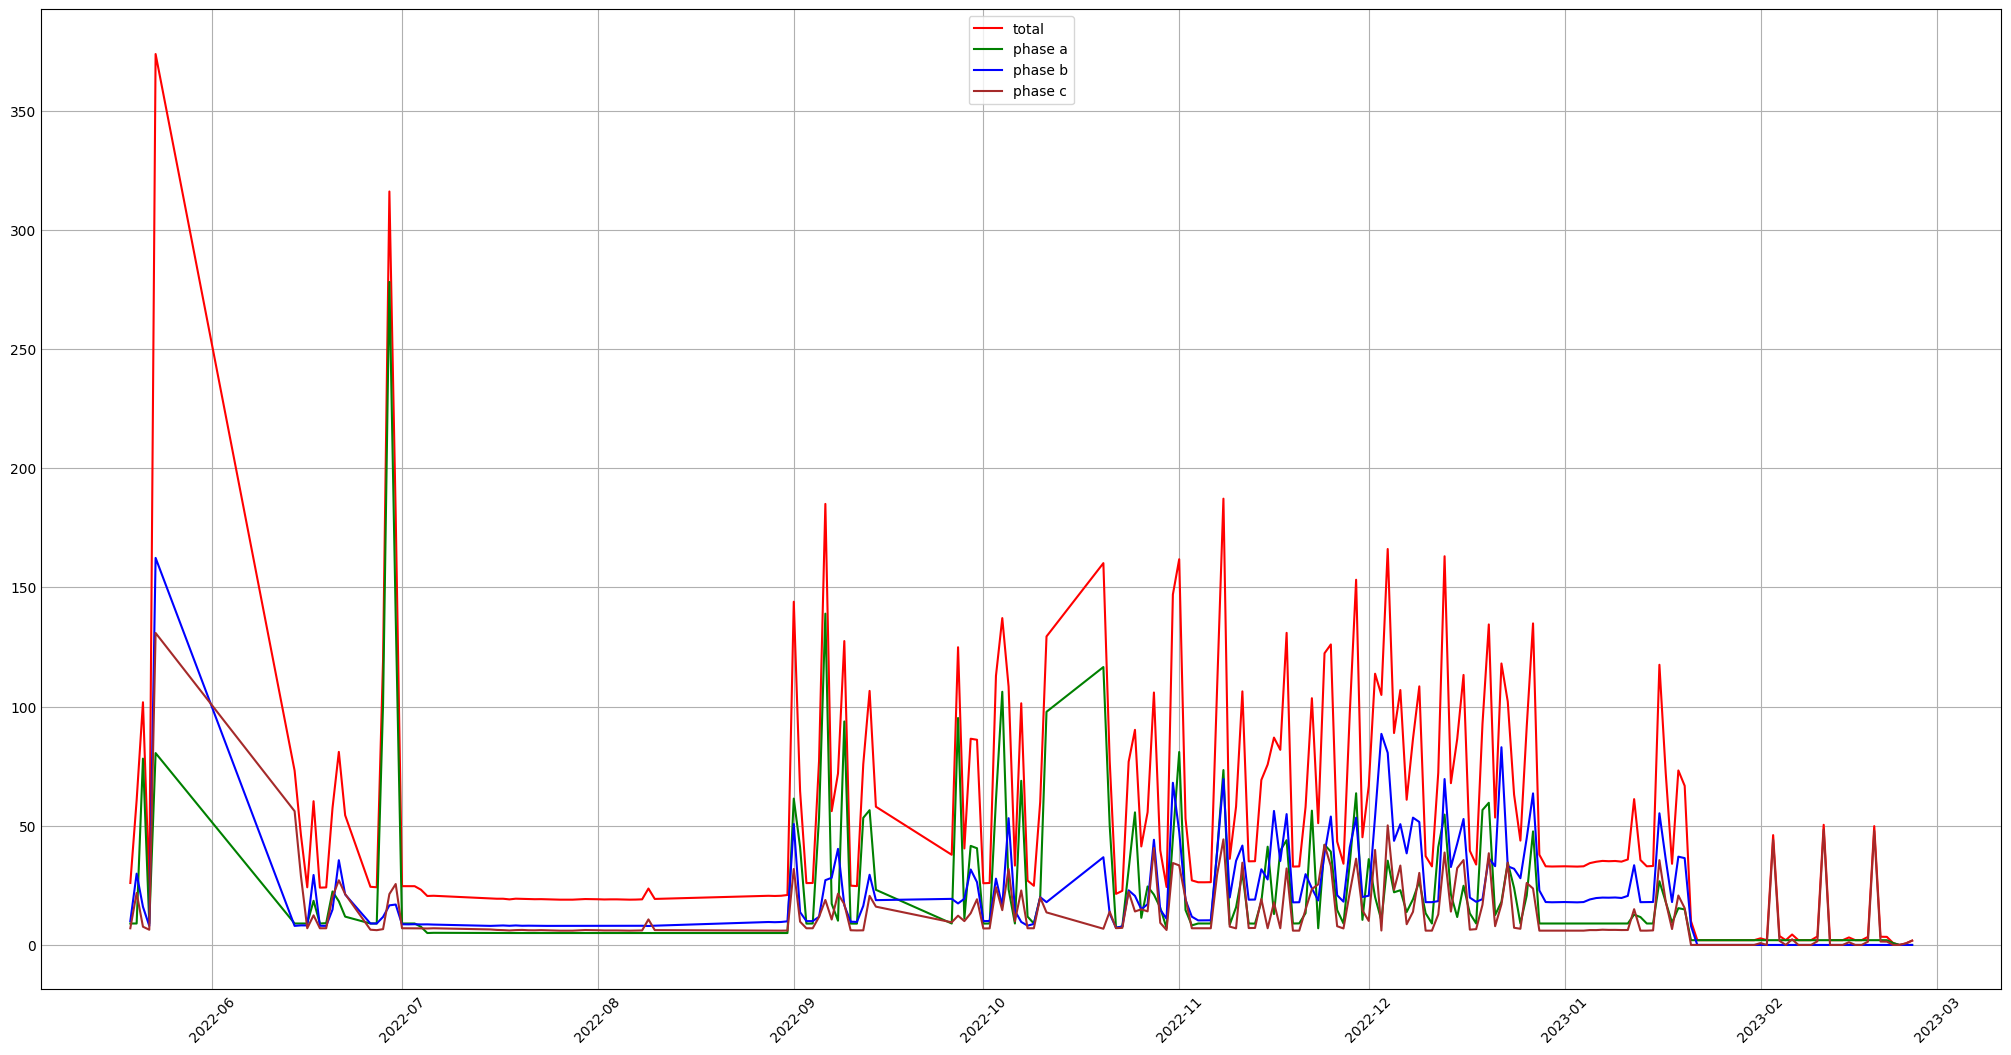

In [85]:
sample_resampled_power_df = resampled_power_df.loc[(resampled_power_df.datetime>=datetime.datetime(year=2022, month=12, day=1, hour=0)) & (resampled_power_df.datetime<=datetime.datetime(year=2023, month=2, day=2, hour=0))]
show_sample(resampled_power_df)

Давайте сравним графики

In [86]:
sample_from_datetime = datetime.datetime(year=2022, month=12, day=1, hour=0)
sample_to_datetime = datetime.datetime(year=2023, month=2, day=1, hour=0)

original_power_df = power_df.loc[(power_df.datetime > sample_from_datetime) & (power_df.datetime <= sample_to_datetime)]
avg_power_df = resampled_power_df.loc[(resampled_power_df.datetime > sample_from_datetime) & (resampled_power_df.datetime <= sample_to_datetime)]

raw_power_x = original_power_df.datetime
avg_power_x = avg_power_df.datetime


Синей линией на графике отображаются оригинальные данные. Красной линией отображаются семплированные данные.
Как видно на графике семплированные данные менее хаотичные, чем сырые данные.

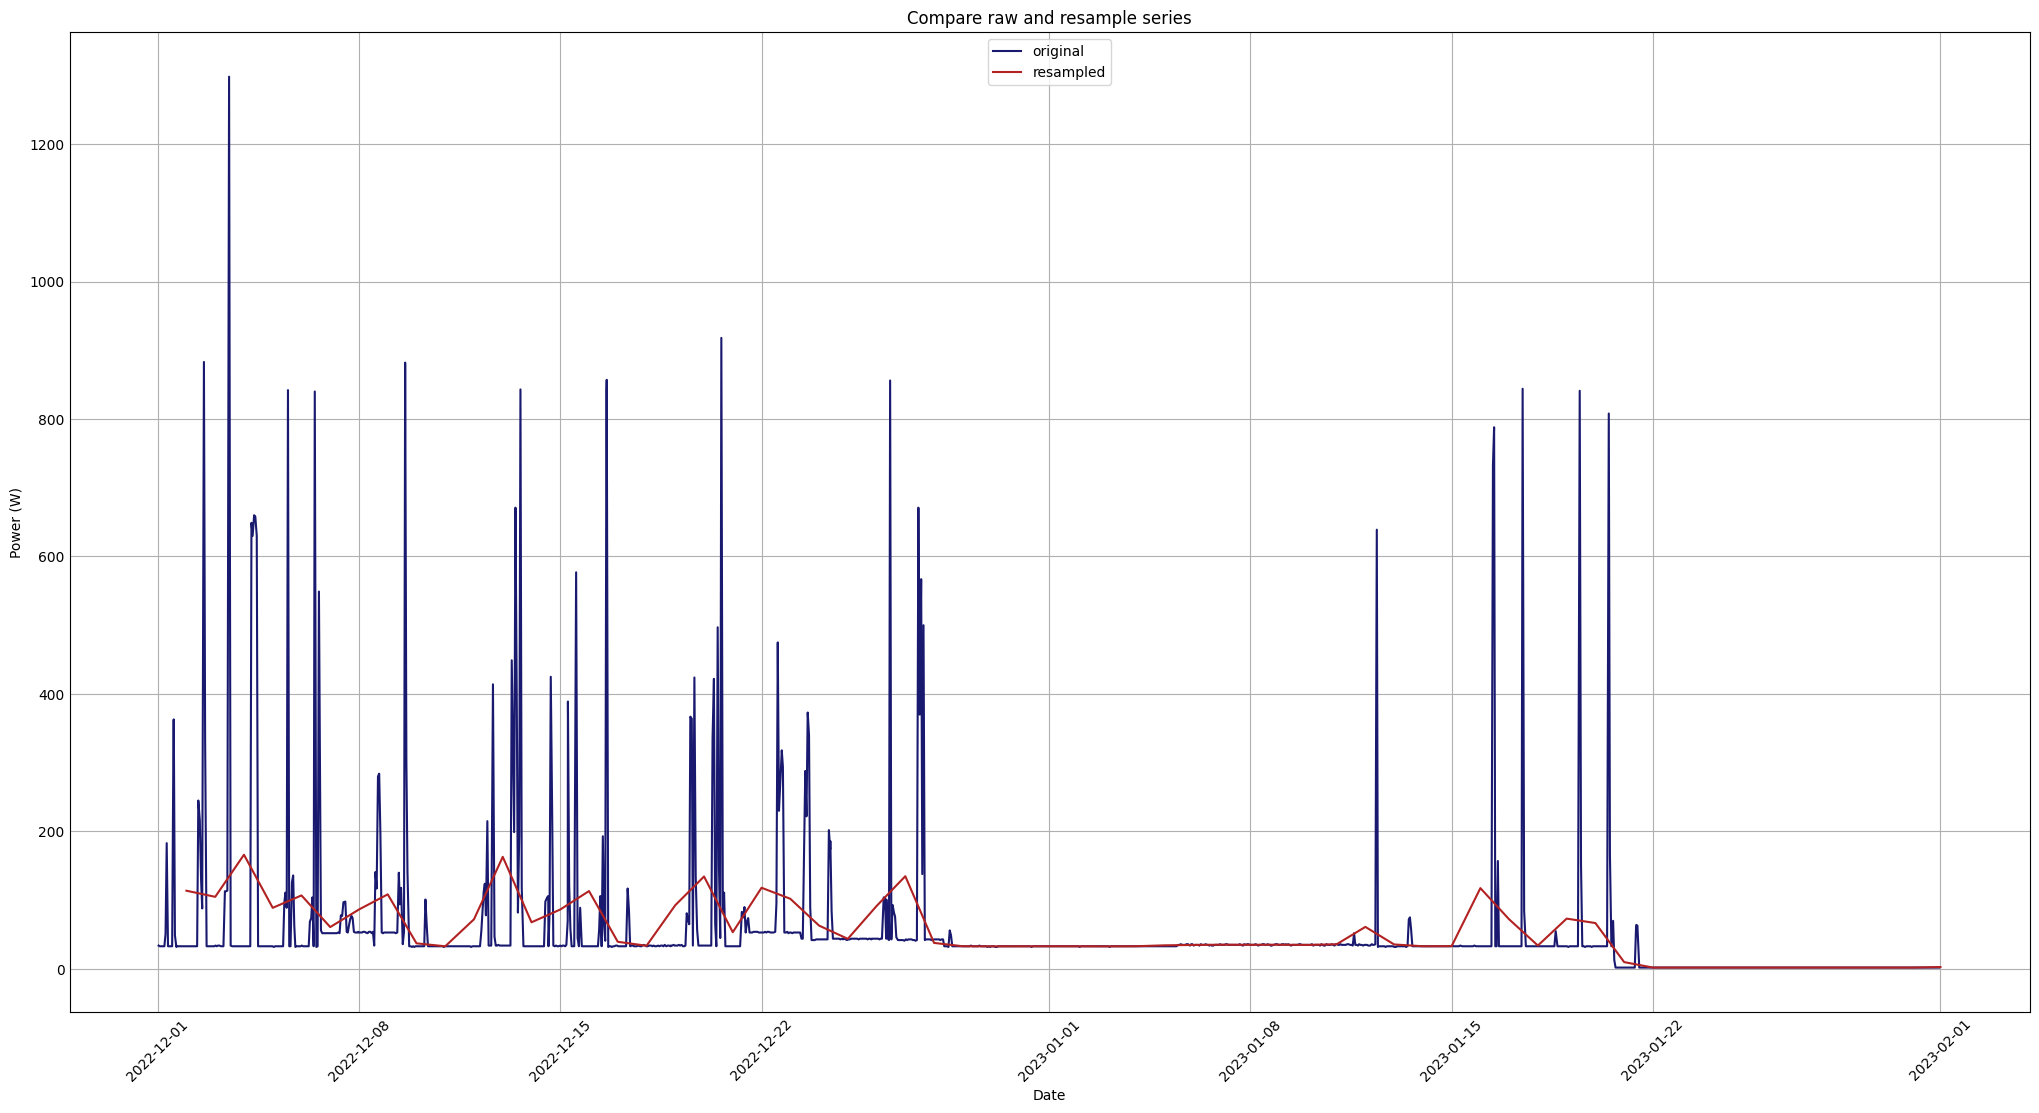

In [87]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Compare raw and resample series")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(raw_power_x, original_power_df[data_colum_name], color = "midnightblue", label = "original")
plt.plot(avg_power_x, avg_power_df.total, color = "firebrick", label = "resampled")

plt.legend(loc='upper center')
plt.show()

Создадим набор тестовых и тренировачных данных

In [88]:
resampled_train_df = resampled_power_df.loc[(resampled_power_df.datetime>=from_datetime) & (resampled_power_df.datetime<=separation_datetime)]
resampled_test_df = resampled_power_df.loc[(resampled_power_df.datetime>separation_datetime) & (resampled_power_df.datetime <= to_datetime)]
print(len(resampled_train_df), len(resampled_test_df))

43 14


In [89]:
# print("ARMA")
arma_best_model, arma_best_rmse = find_best_model(SARIMAX, resampled_test_df)


(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 76.20634172512055
(0, 0, 1) is better than (0, 0, 0) | 76.20634172512055 -> 75.16478241244324
(0, 0, 2) is better than (0, 0, 1) | 75.16478241244324 -> 74.90243170438086
blah
(0, 0, 5) is better than (0, 0, 2) | 74.90243170438086 -> 74.414797602223
(0, 1, 0) is better than (0, 0, 5) | 74.414797602223 -> 46.15664824253239
(0, 1, 1) is better than (0, 1, 0) | 46.15664824253239 -> 44.11987612583039
(0, 1, 4) is better than (0, 1, 1) | 44.11987612583039 -> 44.07485287057443
blah
blah
Error! Continue
Error! Continue
Error! Continue
Error! Continue
(2, 1, 0) is better than (0, 1, 4) | 44.07485287057443 -> 43.628085040255655
(2, 1, 4) is better than (2, 1, 0) | 43.628085040255655 -> 39.41292008753874
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
(5, 0, 5) is better than (2, 1, 4) | 39.41292008753874 -> 38.878657624121296
Error! Continue
Error! Conti

In [90]:
# print("\nARIMA")
arima_best_model, arima_best_rmse = find_best_model(ARIMA, resampled_test_df)

(0, 0, 0) is better than (0, 0, 0) | 1000000 -> 44.119875495641395
blah
(0, 0, 5) is better than (0, 0, 0) | 44.119875495641395 -> 43.886178733912914
blah
blah
Error! Continue
Error! Continue
Error! Continue
Error! Continue
(2, 1, 0) is better than (0, 0, 5) | 43.886178733912914 -> 43.628085040255655
(2, 1, 4) is better than (2, 1, 0) | 43.628085040255655 -> 39.41292008753874
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue
Error! Continue


In [91]:
print("RMSE")
print("arima:", arima_best_rmse, "| arma:", arma_best_rmse)
print("Models")
print("arima:", arima_best_model, "| arma:", arma_best_model)

RMSE
arima: 39.41292008753874 | arma: 38.878657624121296
Models
arima: (2, 1, 4) | arma: (5, 0, 5)


In [92]:
y = resampled_test_df[data_colum_name]

ARIMAmodel = ARIMA(y, order = arima_best_model)
ARIMAmodel = ARIMAmodel.fit()

arima_pred = ARIMAmodel.get_forecast(len(resampled_test_df.index))
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = resampled_test_df["datetime"]
arima_pred_out = arima_pred_df["Predictions"] 


In [93]:
y = resampled_test_df[data_colum_name]

ARMAmodel = SARIMAX(y, order = arma_best_model)
ARMAmodel = ARMAmodel.fit()

arma_pred = ARMAmodel.get_forecast(len(resampled_test_df.index))
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Predictions"] = ARMAmodel.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = resampled_test_df["datetime"]
arma_pred_out = arma_pred_df["Predictions"] 

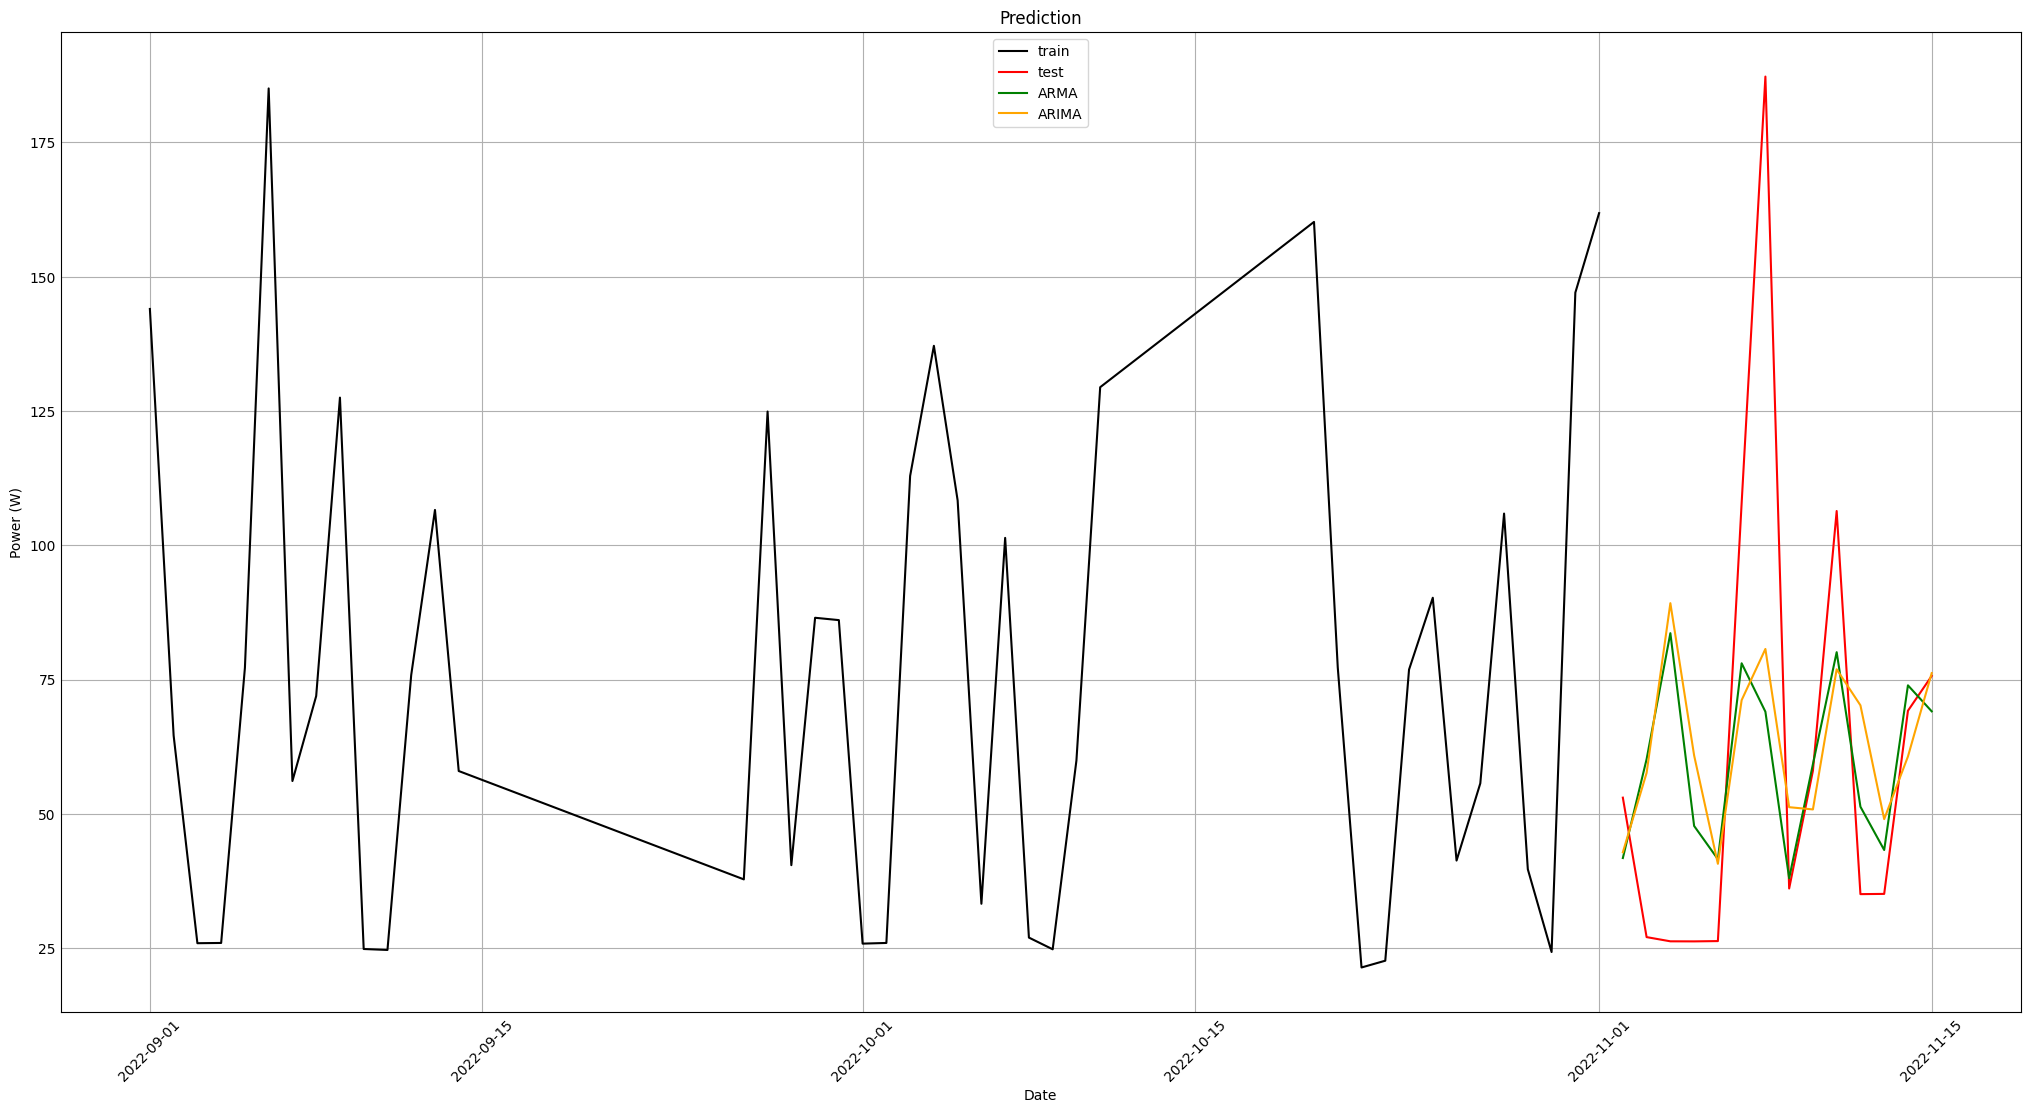

In [94]:
train_x = list(resampled_train_df.index)
test_x = list(resampled_test_df.index)

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)
plt.title("Prediction")
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Power (W)')

plt.plot(train_x, resampled_train_df[data_colum_name], color = "black", label = "train")
plt.plot(test_x, resampled_test_df[data_colum_name], color = "red", label = "test")

plt.plot(arma_pred_out, color='green', label = 'ARMA')
plt.plot(arima_pred_out, color='orange', label = 'ARIMA')

plt.legend(loc='upper center')
plt.show()

In [95]:
arma_rmse = np.sqrt(mean_squared_error(resampled_test_df[data_colum_name].values, arma_pred_out))
arima_rmse = np.sqrt(mean_squared_error(resampled_test_df[data_colum_name].values, arima_pred_out))
print("Arma RMSE:",arma_rmse, "| Arima RMSE:", arima_rmse)

Arma RMSE: 38.878657624121296 | Arima RMSE: 39.41292008753874
